In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
print(tf.__version__)

from keras.layers import Dense
from keras.models import Model, Sequential

from keras import initializers

/home/minesh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


Using TensorFlow backend.


In [57]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

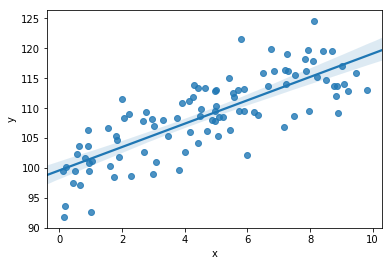

In [2]:

## ---------- Create our linear dataset ---------------
## Set the mean, standard deviation, and size of the dataset, respectively
mu, sigma, size = 0, 4, 100

## Set the slope (m) and y-intercept (b), respectively
m, b = 2, 100

## Create a uniformally distributed set of X values between 0 and 10 and store in pandas dataframe
x = np.random.uniform(0,10, size)
df = pd.DataFrame({'x':x})

## Find the "perfect" y value corresponding to each x value given
df['y_perfect'] = df['x'].apply(lambda x: m*x+b)


## Create some noise and add it to each "perfect" y value to create a realistic y dataset
df['noise'] = np.random.normal(mu, sigma, size=(size,))
df['y'] = df['y_perfect']+df['noise']

## Plot our noisy dataset with a standard linear regression 
## (note seaborn, the plotting library, does the linear regression by default)
ax1 = sns.regplot(x='x', y='y', data=df)


In [147]:
from keras.callbacks import *
es = EarlyStopping(min_delta=0.00001,patience=50,verbose=2)
cp = ModelCheckpoint("bst_model_wts.hdf5",save_best_only=True)
rlop = ReduceLROnPlateau(patience=15,factor=0.999,verbose=1,min_delta=10)
clr = CyclicLR(base_lr=0.0001, max_lr=0.03,
                        step_size=20., mode='triangular')

In [65]:
class SGDLearningRateTracker(Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        
        lr = K.eval( tf.cast(optimizer.lr , tf.float32)
                    * (1. / (1. + 
                            tf.cast(optimizer.decay , tf.float32)*
                            tf.cast(optimizer.iterations , tf.float32)
                            )))
        print('\nLR: {:.6f}\n'.format(lr))
lr_track=SGDLearningRateTracker()

In [148]:

##---------- Create our Keras Model -----------------
## Create our model with a single dense layer, with a linear activation function and glorot (Xavier) input normalization
model = Sequential([
        Dense(1, activation='linear', input_shape=(1,), kernel_initializer='glorot_uniform')
    ])

from keras.optimizers import SGD

sgd=SGD(0.03,decay=0.0001)
## Compile our model using the method of least squares (mse) loss function 
## and a stochastic gradient descent (sgd) optimizer
model.compile(loss='mse', optimizer=sgd) ## To try our model with an Adam optimizer simple replace 'sgd' with 'Adam'

## Set our learning rate to 0.01 and print it
# model.optimizer.lr.set_value(.001)
# print (model.optimizer.lr.get_value())

## Fit our model to the noisy data we create above. Notes: 
## The validation split parameter reserves 20% of our data for validation (ie 80% will be used for training)
## I don't really know if using a batch size of 1 makes sense
history = model.fit(x=df['x'], y=df['y'], validation_split=0.2
                    , batch_size=1, epochs=1000 # bs=100
                    , callbacks=[es,rlop,cp]
                   )


Train on 80 samples, validate on 20 samples
Epoch 1/1000
80/80 [==============================] - 2s 22ms/step - loss: 29304868.7704 - val_loss: 166253611.8500
Epoch 2/1000
80/80 [==============================] - 0s 2ms/step - loss: 365909333281.6063 - val_loss: 1959544128.0000
Epoch 3/1000
80/80 [==============================] - 0s 2ms/step - loss: 52729564426.9859 - val_loss: 61257415910.4000
Epoch 4/1000
80/80 [==============================] - 0s 2ms/step - loss: 492951332404.6504 - val_loss: 4872737448.0000
Epoch 5/1000
80/80 [==============================] - 0s 2ms/step - loss: 2372873681421.9839 - val_loss: 75387766616883.2031
Epoch 6/1000
80/80 [==============================] - 0s 2ms/step - loss: 78207605224459.2031 - val_loss: 29442925564.8000
Epoch 7/1000
80/80 [==============================] - 0s 2ms/step - loss: 1309871851018.7688 - val_loss: 2836933266022.3999
Epoch 8/1000
80/80 [==============================] - 0s 2ms/step - loss: 46759747182370792.0000 - val_loss:

80/80 [==============================] - 0s 3ms/step - loss: 459.1665 - val_loss: 22.5458
Epoch 73/1000
80/80 [==============================] - 0s 4ms/step - loss: 92.9948 - val_loss: 25.6914
Epoch 74/1000
80/80 [==============================] - 0s 5ms/step - loss: 197.6622 - val_loss: 2152.3315
Epoch 75/1000
80/80 [==============================] - 0s 4ms/step - loss: 645.8859 - val_loss: 45.1623
Epoch 76/1000
80/80 [==============================] - 0s 3ms/step - loss: 76.9980 - val_loss: 290.3416
Epoch 77/1000
80/80 [==============================] - 0s 3ms/step - loss: 372.3467 - val_loss: 34.4884
Epoch 78/1000
80/80 [==============================] - 0s 5ms/step - loss: 73.7526 - val_loss: 19.8743
Epoch 79/1000
80/80 [==============================] - 0s 5ms/step - loss: 61.9870 - val_loss: 114.9071
Epoch 80/1000
80/80 [==============================] - 0s 4ms/step - loss: 111.6028 - val_loss: 787.7047

Epoch 00080: ReduceLROnPlateau reducing learning rate to 0.02988017935864627

Epoch 147/1000
80/80 [==============================] - 0s 3ms/step - loss: 30.7012 - val_loss: 20.4343
Epoch 148/1000
80/80 [==============================] - 0s 3ms/step - loss: 37.0177 - val_loss: 19.9109
Epoch 149/1000
80/80 [==============================] - 0s 3ms/step - loss: 32.1214 - val_loss: 21.4824
Epoch 00149: early stopping


dict_keys(['val_loss', 'loss', 'lr'])


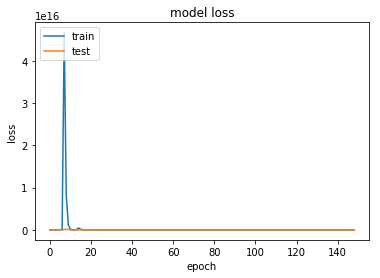

In [149]:
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt

# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# # axes = plt.gca()
# # axes.set_xlim([0,120])
# # axes.set_ylim([90,100])
# plt.savefig('acc.png')  # save the figure to file
# plt.show()
# plt.close()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss.png')
plt.show()

In [151]:
model.load_weights("bst_model_wts.hdf5")
# Compile model (required to make predictions)
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


m=2.04 b=99.08



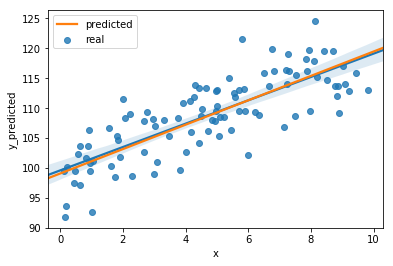

In [152]:


## ---------- Review our weights -------------------
## Save and print our final weights
predicted_m = model.get_weights()[0][0][0]
predicted_b = model.get_weights()[1][0]
print ("\nm=%.2f b=%.2f\n" % (predicted_m, predicted_b))

## Create our predicted y's based on the model
df['y_predicted'] = df['x'].apply(lambda x: predicted_m*x + predicted_b)

## Plot the original data with a standard linear regression
ax1 = sns.regplot(x='x', y='y', data=df, label='real')

## Plot our predicted line based on our Keras model's slope and y-intercept
ax2 = sns.regplot(x='x', y='y_predicted', data=df, scatter=False, label='predicted')
ax2.legend(loc="upper left")